# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import yfinance as yf

import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [137]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [138]:
device

device(type='cpu')

In [139]:
ticker = 'MSFT'
df=yf.download(ticker,'2020-01-01')

C:\Users\Siddharth\AppData\Local\Temp\ipykernel_41500\570675951.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df=yf.download(ticker,'2020-01-01')
[*********************100%***********************]  1 of 1 completed


In [140]:
df

Price,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,
2020-01-02,152.791122,152.895761,150.612747,151.040810,22622100
2020-01-03,150.888641,152.153817,150.355939,150.603275,21116200
2020-01-06,151.278671,151.345266,148.881495,149.423720,20813700
2020-01-07,149.899323,151.887449,149.652001,151.554518,21634100
2020-01-08,152.286957,152.962357,150.251264,151.183494,27746500
...,...,...,...,...,...
2025-08-25,504.260010,508.190002,504.119995,506.630005,21638600
2025-08-26,502.040009,504.980011,498.510010,504.359985,30835700


<Axes: xlabel='Date'>

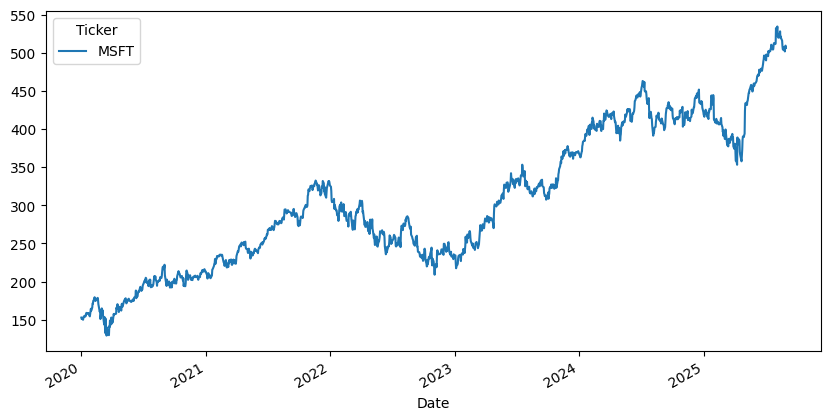

In [141]:
df.Close.plot(figsize=(10,5))

In [142]:
scaler = StandardScaler()
df['Close']=scaler.fit_transform(df['Close'])

In [143]:
df.Close

Ticker,MSFT
Date,
2020-01-02,-1.641304
2020-01-03,-1.661737
2020-01-06,-1.657548
2020-01-07,-1.672363
2020-01-08,-1.646719
...,...
2025-08-25,2.133642
2025-08-26,2.109798
2025-08-27,2.160278


In [144]:
seq_length= 30
data=[]

for i in range(len(df)-seq_length):
    data.append(df.Close[i:i+seq_length])

data=np.array(data)
train_size=int(0.8*len(data))
X_train=torch.from_numpy(data[:train_size,:-1,:]).type(torch.Tensor).to(device)

In [145]:
y_train=torch.from_numpy(data[:train_size,-1,:]).type(torch.Tensor).to(device)
X_test=torch.from_numpy(data[train_size:,:-1,:]).type(torch.Tensor).to(device)
y_test=torch.from_numpy(data[train_size:,-1,:]).type(torch.Tensor).to(device)

In [146]:
y_train

tensor([[-1.4054],
        [-1.3886],
        [-1.3694],
        ...,
        [ 1.5011],
        [ 1.4373],
        [ 1.4037]])

In [147]:
class PredictinModel(nn.Module):
    def __init__(self,input_dim,hidden_dim,num_layers,output_dim):
        super(PredictinModel,self).__init__()

        self.num_layers=num_layers
        self.hidden_dim = hidden_dim

        self.lstm=nn.LSTM(input_dim,hidden_dim,num_layers,batch_first=True)
        self.fc=nn.Linear(hidden_dim,output_dim)

    def forward(self,x):
        h0= torch.zeros(self.num_layers,x.size(0),self.hidden_dim,device=device)
        c0= torch.zeros(self.num_layers,x.size(0),self.hidden_dim,device=device)

        out,(hn,cn)=self.lstm(x,(h0.detach(),c0.detach()))
        out=self.fc(out[:,-1,:])

        return out

In [148]:
model=PredictinModel(input_dim=1,hidden_dim=32,num_layers=2,output_dim=1).to(device)

In [149]:
criterion = nn.MSELoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [150]:
num_epoch=200

for i in range(num_epoch):
    y_train_pred=model(X_train)

    loss=criterion(y_train_pred,y_train)

    if i%25==0:
        print(i,loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


0 0.6126394271850586
25 0.27446964383125305
50 0.033212509006261826
75 0.012734143063426018
100 0.008936631493270397
125 0.008392470888793468
150 0.007992302067577839
175 0.0076722945086658


In [151]:
model.eval()
y_test_pred=model(X_test)

y_train_pred=scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train=scaler.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred=scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test=scaler.inverse_transform(y_test.detach().cpu().numpy())


In [152]:
train_rmse=root_mean_squared_error(y_train[:,0],y_train_pred[:,0])
test_rmse=root_mean_squared_error(y_test[:,0],y_test_pred[:,0])

In [153]:
train_rmse

8.004809379577637

In [154]:
test_rmse

20.876041412353516

Text(0, 0.5, 'Price')

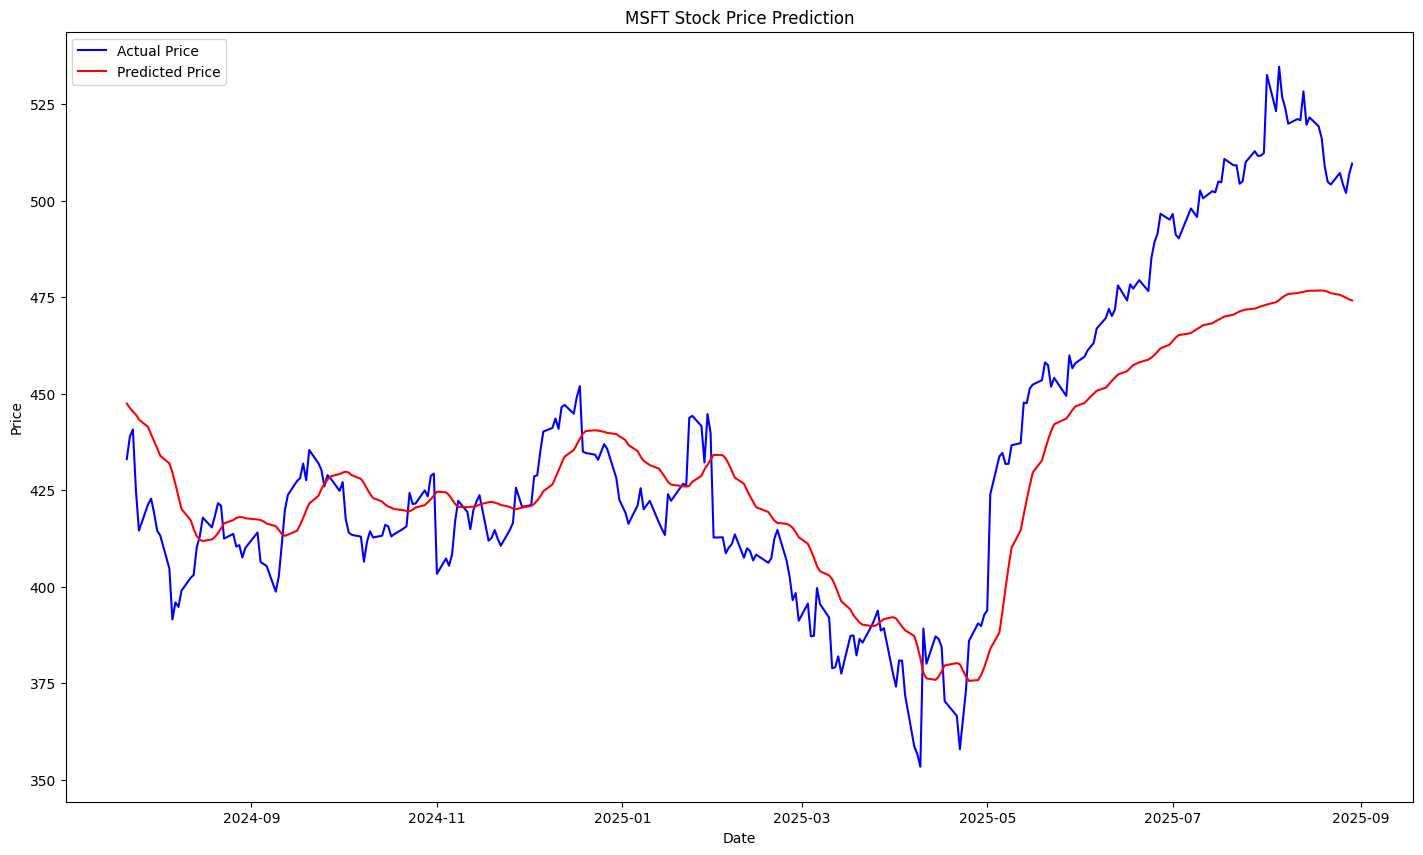

In [155]:
fig=plt.figure(figsize=(80,10))

gs=fig.add_gridspec(ncols=4,nrows=1)

ax1=fig.add_subplot(gs[:3,0])
ax1.plot(df.iloc[-len(y_test):].index,y_test,color='blue',label='Actual Price')
ax1.plot(df.iloc[-len(y_test):].index,y_test_pred,color='red',label='Predicted Price')
ax1.legend()
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel('Date')
plt.ylabel('Price')

